In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
df = pd.read_csv("DataSet/StoreTSTrain.csv")

In [4]:
df = df[(df['store']==0) & (df['product']==0)][['Date','number_sold']]
df = df.rename(columns = {'Date':'date','number_sold':'sold'})
df.head()

,date,sold
0,2010-01-01,801
1,2010-01-02,810
2,2010-01-03,818
3,2010-01-04,796
4,2010-01-05,808


In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3287 non-null   object
 1   sold    3287 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.0+ KB


**converting - date to date time column**

In [7]:
df['date'] = pd.to_datetime(df['date'])

**date column type has changed**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3287 non-null   datetime64[ns]
 1   sold    3287 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 77.0 KB


In [9]:
df.describe()

,date,sold
count,3287,3287.000000
mean,2014-07-02 00:00:00,828.676909
min,2010-01-01 00:00:00,747.000000
25%,2012-04-01 12:00:00,795.000000
50%,2014-07-02 00:00:00,828.000000
75%,2016-09-30 12:00:00,863.000000
max,2018-12-31 00:00:00,921.000000
std,NaN,38.402983


<Axes: >

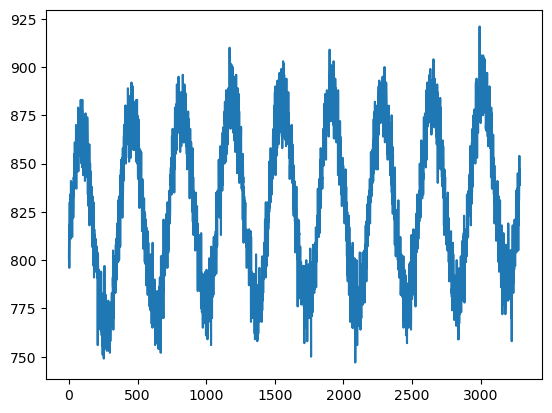

In [10]:
# plotting to see the trends
df['sold'].plot()

In [11]:
df.shape

(3287, 2)

<Axes: >

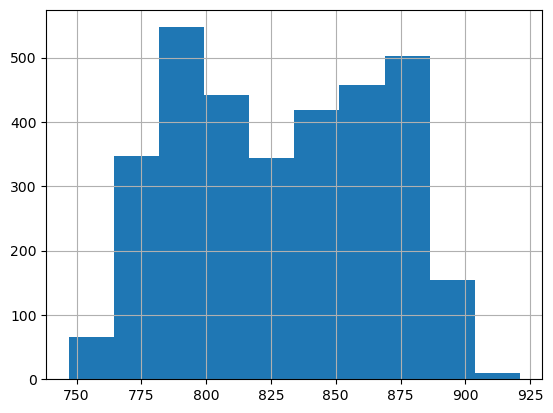

In [12]:
df['sold'].hist()

**Doesn't look skewed**

In [13]:
df['sold'].skew()

np.float64(0.015579249700462648)

**A little bit skewed on the right since it is >0 but since it lies betwwen -1 and +1 it is considered to be approximately symmetric**

In [14]:
df_part1 = df[0:int(len(df)/2)]
df_part2 = df[int(len(df)/2):]

In [15]:
print('part1 mean: ',df_part1['sold'].mean())
print('part2 mean: ',df_part2['sold'].mean())

part1 mean:  828.6743761412051
part2 mean:  828.6794403892944


In [16]:
print('part1 standard deviation: ',df_part1['sold'].std())
print('part2 standard deviation: ',df_part2['sold'].std())

part1 standard deviation:  38.600524373032165
part2 standard deviation:  38.21628604697317


**Checking if different parts of the data gives same or different kind of means and standard deviations**

###  Rolling mean - To see the smoothed data by calculating the rolling mean

<Axes: >

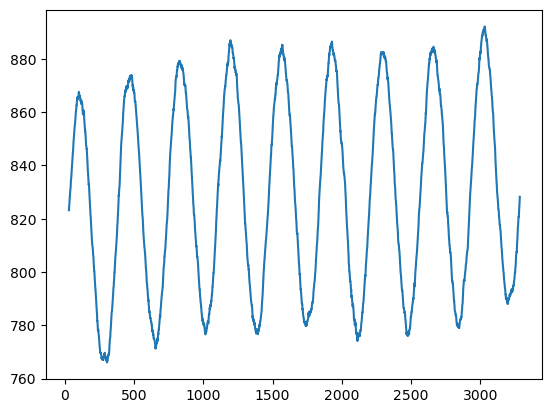

In [17]:
df['sold'].rolling(window=30).mean().plot()

### Checking for trends, seasonality and residual

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_additive = seasonal_decompose(df['sold'],model = 'additive',period = 30)
decomp_additive

In [19]:
season = decomp_additive.seasonal
trend = decomp_additive.trend
residual = decomp_additive.resid

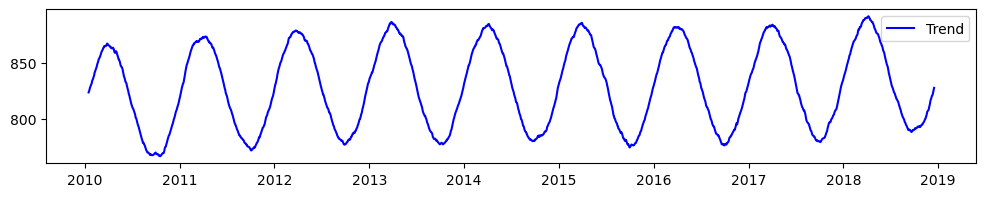

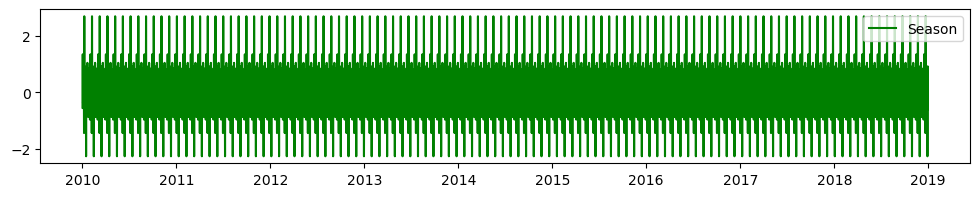

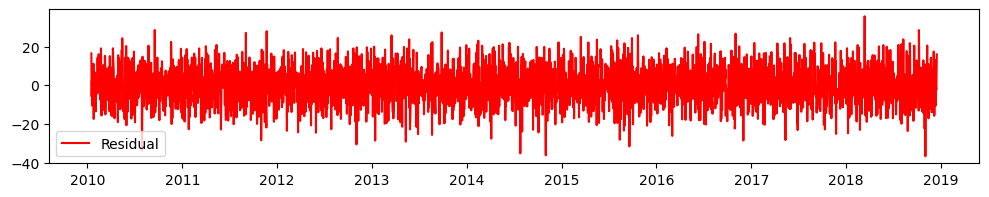

In [20]:
plt.figure(figsize = (12,2))
plt.plot(df['date'],trend,'blue',label = 'Trend')
plt.legend()
plt.show()

plt.figure(figsize = (12,2))
plt.plot(df['date'],season,color = 'green',label = 'Season')
plt.legend()
plt.show()

plt.figure(figsize = (12,2))
plt.plot(df['date'],residual,color = 'red', label = 'Residual')
plt.legend()
plt.show()

### Checking if our data is stationary

In [21]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df['date'])
adf[1]

C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


1.0

In [22]:
if adf[1]< 0.05:
    print('Data is stationary')
else:
    print('Data is not stationary')

Data is not stationary


In [23]:
from statsmodels.tsa.stattools import kpss
kpss = kpss(df['date'], regression = 'ct')
kpss[1]

C:\Users\mahta\AppData\Local\Temp\ipykernel_7196\4213695444.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss(df['date'], regression = 'ct')


np.float64(0.01)

In [24]:
if kpss[1] > 0.05:
    print('Data is stationary')
else:
    print('Data is not stationary')

Data is not stationary


**Conclusion: Contradictory Results**

* ADF says stationary

* KPSS says not stationary

It usually means our data is trend-stationary (i.e., stationary after removing a deterministic trend).

Not strict stationary --->> might require some detrending or differencing

### Creating the baseline model

In [25]:
df['baseline_sold'] = df['sold'].shift(1)

In [26]:
df.dropna(inplace=True)

In [27]:
from sklearn.metrics import mean_squared_error

print('MSE : ',mean_squared_error(df['sold'],df['baseline_sold']))
print('RMSE : ',np.sqrt(mean_squared_error(df['sold'],df['baseline_sold'])))

MSE :  196.25319537431528
RMSE :  14.00903977345754


Any model we create later should give an error less than the above error

### We are going to use the ARIMA model 

To shortlist the combination of p, d and q we plot the acf and pacf plots

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

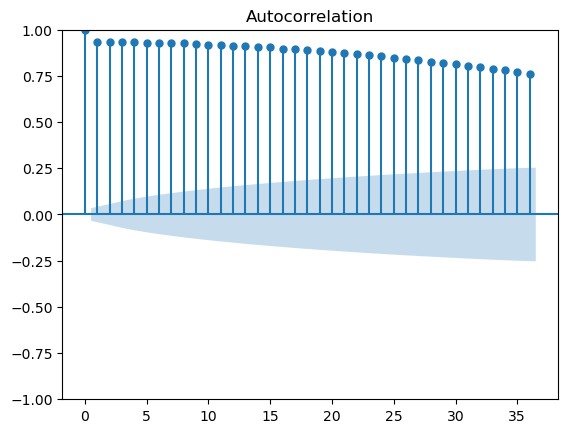

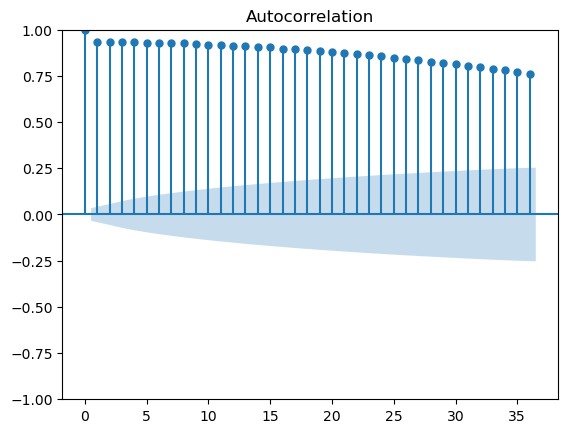

In [29]:
plot_acf(df['sold'])

It means here that at 0 what is the correlation of the sold column with itself and at 1 i.e., what is the correlation between t & t-1, t-1 & t-2,...
for 2 we have the correlation between t & t-12, t-1 & t-3,...

### What the plot shows:

* **Y-axis**: Correlation values (from -1 to +1).
* **X-axis**: Lag values (how far back in time you look).
* **Blue shaded area**: Confidence interval (usually 95%). If bars go outside this band, correlations are significant.


### Observations from our plot:

1. **High autocorrelation at all lags**

   * The bars are very close to 1, even up to lag 35.
   * This means each value in your series is **highly correlated with its past values**.

2. **Slow decay**

   * The autocorrelation decreases gradually as lag increases.
   * This is a classic sign of **non-stationarity** in the data (the mean/variance may be changing over time).

3. **No clear seasonality**

   * There are no repeating up-and-down spikes (like at lag 12, 24, etc.), so no obvious seasonality is visible here.

### Interpretation:

* Your time series is **non-stationary**.
* Likely has a **trend** (values increasing or decreasing consistently over time).
* Standard models like AR, ARMA, or linear regression will not work well on this raw series.


### Next Steps:

1. **Differencing**: Apply first-order differencing (`y[t] - y[t-1]`) to remove trend and make series stationary.
2. **Check ACF & PACF again**: After differencing, the ACF should drop to near zero quickly if stationarity is achieved.
3. **Using models for non-stationary data**:

   * **ARIMA** (with differencing term `d`)
   * **SARIMA** if you later find seasonality

In short:

This ACF plot is telling you **“your series is highly autocorrelated and non-stationary — difference it before modeling.”**

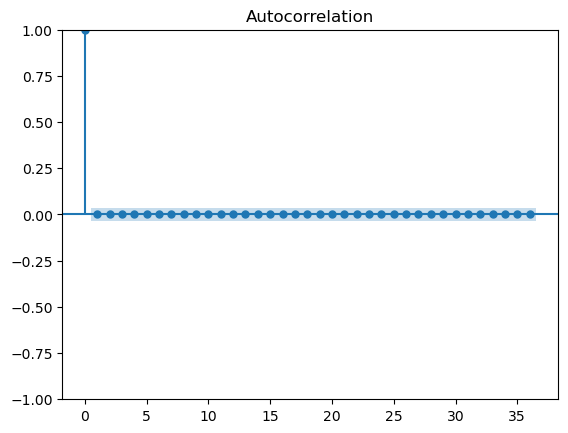

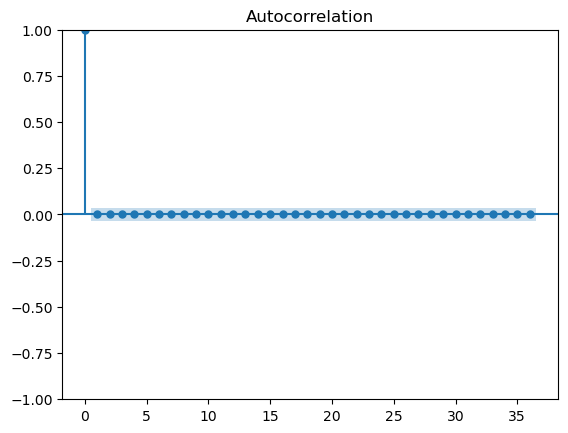

In [30]:
plot_acf(df['date'].diff())

### Observations

1. **Lag 0 = 1 (as expected)**

   * At lag 0, correlation is always 1, since the series is perfectly correlated with itself.

2. **No significant correlations at other lags**

   * All other bars are **close to zero** and fall well inside the blue confidence band.
   * This means there’s **no significant autocorrelation** remaining in the differenced series.

### Interpretation

* After differencing, the series is now **stationary**.
* The trend component (that caused high correlation earlier) has been removed.
* Now, the series behaves like a **white noise process** (random, no predictable correlation structure).

✅ **In short**:
Our differencing worked. The second ACF plot confirms the data is now stationary and ready for ARIMA modeling.

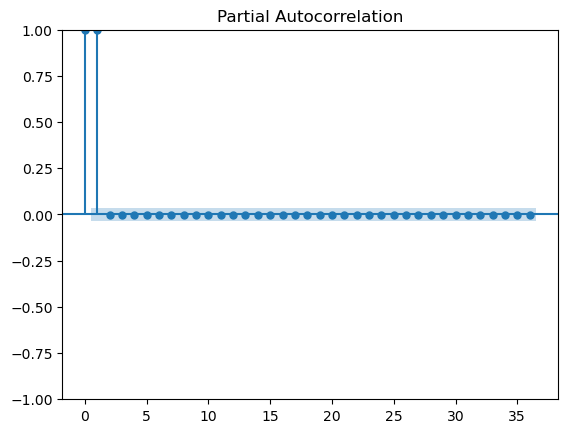

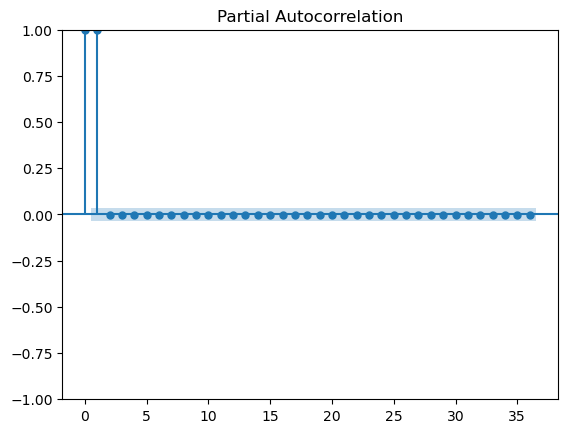

In [31]:
plot_pacf(df['date'])

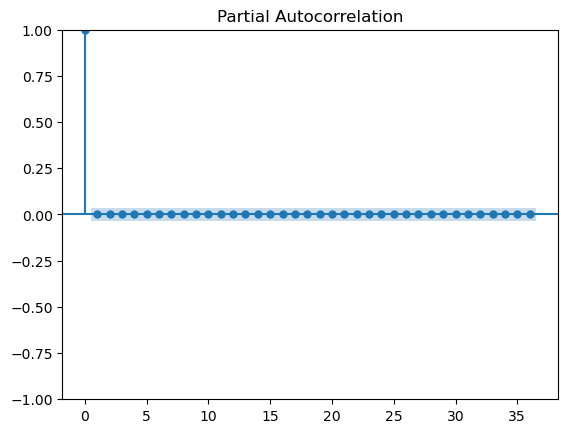

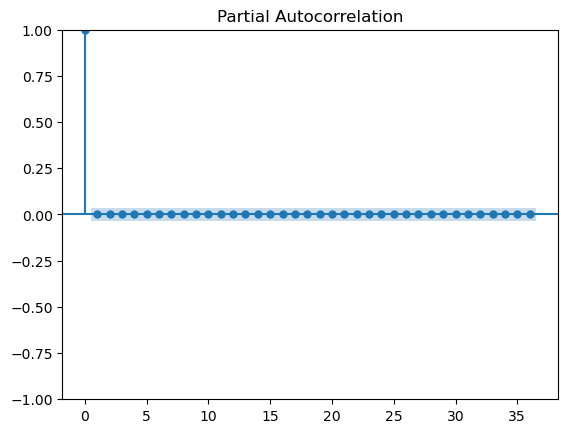

In [32]:
plot_pacf(df['date'].diff())

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
df.shape

(3286, 3)

In [35]:
test = pd.read_csv("DataSet/StoreTSTest.csv")
test = test[(test['store']==0) & (test['product']==0)]
test.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [36]:
arima = ARIMA(df['sold'],order = (1,1,0))
model = arima.fit()
model.forecast()

C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_mode

3286    843.035105
dtype: float64

**model.forecast()**  - predicts the next value (one-step ahead by default).

**model.forecast(steps=11)**  - predicts the next 11 future values.

In [37]:
predicted_100 = model.forecast(100)

C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
test.size

1460

In [39]:
test_100 = test[:100]['number_sold']
test_100

0     845
1     851
2     840
3     842
4     845
     ... 
95    899
96    907
97    912
98    898
99    893
Name: number_sold, Length: 100, dtype: int64

In [40]:
print('MSE : ',mean_squared_error(test_100,predicted_100))
print('RMSE : ',np.sqrt(mean_squared_error(test_100,predicted_100)))

MSE :  1912.0503523686068
RMSE :  43.726997980293675


**Performing worst than baseline model**

#### Trying all other combinations

In [41]:
train_data = df.set_index('date')
train_data = train_data['sold']
train_data = train_data.asfreq('D')
train_data

date
2010-01-02    810
2010-01-03    818
2010-01-04    796
2010-01-05    808
2010-01-06    812
             ... 
2018-12-27    847
2018-12-28    854
2018-12-29    839
2018-12-30    847
2018-12-31    839
Freq: D, Name: sold, Length: 3286, dtype: int64

In [42]:
test['Date'] = pd.to_datetime(test['Date'])
test_data = test.set_index('Date')
test_data = test_data['number_sold']
test_data = test_data.asfreq('D')
test_data

Date
2019-01-01    845
2019-01-02    851
2019-01-03    840
2019-01-04    842
2019-01-05    845
             ... 
2019-12-27    848
2019-12-28    856
2019-12-29    855
2019-12-30    862
2019-12-31    854
Freq: D, Name: number_sold, Length: 365, dtype: int64

In [43]:
import time
start_time = time.time()

mse,rmse,ar,i,ma,aic,test_shape = [],[],[],[],[],[],[]

for p in range(3):
    for q in range(3):
        for d in range(2):
            for test_size in (30,60,90,120,150):
                try:
                    order = (p,d,q)
                    arima = ARIMA(train_data,order=order)
                    model = arima.fit()
                    predicted = model.forecast(steps = test_size)
                    mse.append(mean_squared_error(test_data[0:test_size],predicted))
                    rmse.append(np.sqrt(mean_squared_error(test_data[0:test_size],predicted)))
                    ar.append(p)
                    i.append(d)
                    ma.append(q)
                    aic.append(model.aic)
                    test_shape.append(test_size)
                except:
                    continue

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahta\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahta\AppData\R

Time taken: 54.63817739486694 seconds


In [44]:
output = pd.DataFrame(columns = ['ar-p','i-d','ma-q','mse','rmse','aic','test_shape'])
output['ar-p'] = ar
output['i-d'] = i
output['ma-q'] = ma
output['mse'] = mse
output['rmse'] = rmse
output['aic'] = aic
output['test_shape'] = test_shape

In [45]:
output.head()

,ar-p,i-d,ma-q,mse,rmse,aic,test_shape
0,0,0,0,1106.075669,33.257716,33304.288531,30
1,0,0,0,2076.664887,45.570439,33304.288531,60
2,0,0,0,2895.307035,53.808057,33304.288531,90
3,0,0,0,3376.540916,58.108011,33304.288531,120
4,0,0,0,3439.348421,58.645958,33304.288531,150


### Our final selection for Armia

In [46]:
output.sort_values('rmse')

,ar-p,i-d,ma-q,mse,rmse,aic,test_shape
87,2,1,2,128.621122,11.341125,24734.162022,90
57,1,1,2,129.106965,11.362525,24732.784329,90
85,2,1,2,131.564508,11.470157,24734.162022,30
55,1,1,2,132.041516,11.490932,24732.784329,30
86,2,1,2,143.165525,11.965180,24734.162022,60
...,...,...,...,...,...,...,...
13,0,0,1,3377.216765,58.113826,30697.603160,120
34,1,0,0,3388.308951,58.209183,26569.994399,150
24,0,0,2,3438.188734,58.636070,29368.988313,150
4,0,0,0,3439.348421,58.645958,33304.288531,150


In [47]:
output.sort_values('rmse').head(1)

,ar-p,i-d,ma-q,mse,rmse,aic,test_shape
87,2,1,2,128.621122,11.341125,24734.162022,90


In [48]:
arima = ARIMA(train_data,order=(2,1,2))
model = arima.fit()
predicted = model.forecast(steps = 90)
print('MSE : ',mean_squared_error(test_data[0:90],predicted))
print('RMSE : ',np.sqrt(mean_squared_error(test_data[0:90],predicted)))

MSE :  128.62112231727093
RMSE :  11.341125266800951


#### our final selected model with forecasting of 90 days and error = 11.34 for store = 0 and product = 0

AR = 2

I = 1

MA = 2